# 1: Pull & Filter EMBL Transcripts

## 1: Query TSS for human transcripts

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from pyensembl import EnsemblRelease
from pybiomart import Dataset

In [85]:
from pybiomart import Server
server = Server(host="nov2020.archive.ensembl.org")
server.list_marts()

mart = server['ENSEMBL_MART_ENSEMBL']
mart.list_datasets()

dataset = mart['hsapiens_gene_ensembl']

nov2020_attr = dataset.query(attributes=['ensembl_gene_id',
                                           'ensembl_transcript_id',
                                           'external_gene_name',
                                           'strand',
                                           'chromosome_name',
                                           'transcript_biotype',
                                           'transcription_start_site',
                                           'transcript_start',
                                           'transcript_end',
                                           'transcript_tsl',
                                           'description'], use_attr_names=True)

nov2020_attr.rename(columns = {'ensembl_gene_id': 'gene_id',
                            'ensembl_transcript_id': 'tx_id',
                            'external_gene_name': 'gene_name',
                            'chromosome_name': 'chr',
                            'transcript_biotype': 'tx_type',
                            'transcription_start_site': 'tss',
                            'transcript_start': 'tx_start',
                            'transcript_end': 'tx_end',
                            'transcript_tsl': 'tx_tsl'},
                            inplace=True)

nov2020_attr.insert(0, 'organism', 'hg38')    

nov2020_tx_tsl_recode = (nov2020_attr[['tx_tsl']].rename(columns={'tx_tsl': 'tx_string'})
                 .drop_duplicates(subset='tx_string')
                 .assign(tx_tsl=lambda x: x['tx_string']
                         .str.replace(r'^(.*)(\([^\)]*\))$', r'\1', regex=True)
                         .str.strip()
                         .str.replace('tsl', '')
                         .replace({'NA': np.nan})
                         .replace('', np.nan)
                         .astype('Int64')
                         .fillna(999))
                )

# Step 2: Update tx_info DataFrame
nov2020_attr = (nov2020_attr.rename(columns={'tx_tsl': 'tx_string'})
           .merge(nov2020_tx_tsl_recode, on='tx_string', how='left')
           .drop(columns=['tx_string'])
          )

#calculate length of transcript
nov2020_attr['tx_len'] = nov2020_attr['tx_end'] - (nov2020_attr['tx_start'] + 1)                                           

In [90]:
nov2020_attr['chr'] = pd.to_numeric(nov2020_attr['chr'], errors='coerce')
nov2020_attr = nov2020_attr[(nov2020_attr['chr'] >= 1) & (nov2020_attr['chr'] <= 23)]
nov2020_attr = nov2020_attr.reset_index()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


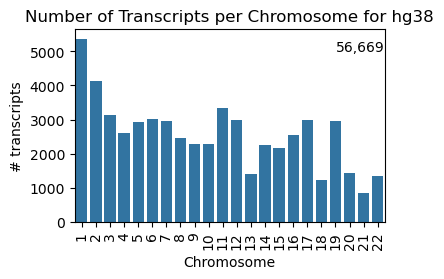

In [93]:
# Convert `chr` to integer and then to a categorical type
nov2020_attr['chr'] = nov2020_attr['chr'].astype(int).astype('category')

# Get distinct combinations of organism, chr, and gene_name
nov2020_tx_info_distinct = nov2020_attr[['organism', 'chr', 'gene_name']].drop_duplicates()

# Create the plot
plt.figure(figsize=(4, 2.5))  # Adjust the figure size as needed
p1 = sns.countplot(data=nov2020_tx_info_distinct, x='chr', dodge=False)

# Adjust plot aesthetics
plt.text(18, 5000, s=f'{len(nov2020_tx_info_distinct):,}')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel('Chromosome')
plt.ylabel('# transcripts')
plt.title('Number of Transcripts per Chromosome for hg38')
plt.show()

## main quest: transcript filter on current ensembl dataset

In [127]:
if not os.path.exists('pilot_design'):
    os.makedirs('pilot_design')
out_dir = 'pilot_design'
out_file = out_dir + '/mouse_human_tx_info.tsv'

#load in ensembl hg38 dataset
hg38_dataset = Dataset(name = 'hsapiens_gene_ensembl',
                  host = 'http://www.ensembl.org')
#attributes to get from hg38 dataset
hg38_attr = hg38_dataset.query(attributes=['ensembl_gene_id',
                                           'ensembl_transcript_id',
                                           'external_gene_name',
                                           'strand',
                                           'chromosome_name',
                                           'transcript_biotype',
                                           'transcription_start_site',
                                           'transcript_start',
                                           'transcript_end',
                                           'transcript_tsl',
                                           'description'], use_attr_names=True)

#rename columns to match Mikhail's data                                           
hg38_attr.rename(columns = {'ensembl_gene_id': 'gene_id',
                            'ensembl_transcript_id': 'tx_id',
                            'external_gene_name': 'gene_name',
                            'chromosome_name': 'chr',
                            'transcript_biotype': 'tx_type',
                            'transcription_start_site': 'tss',
                            'transcript_start': 'tx_start',
                            'transcript_end': 'tx_end',
                            'transcript_tsl': 'tx_tsl'},
                            inplace=True)

hg38_attr.insert(0, 'organism', 'hg38')    

tx_tsl_recode = (hg38_attr[['tx_tsl']].rename(columns={'tx_tsl': 'tx_string'})
                 .drop_duplicates(subset='tx_string')
                 .assign(tx_tsl=lambda x: x['tx_string']
                         .str.replace(r'^(.*)(\([^\)]*\))$', r'\1', regex=True)
                         .str.strip()
                         .str.replace('tsl', '')
                         .replace({'NA': np.nan})
                         .replace('', np.nan)
                         .astype('Int64')
                         .fillna(999))
                )

# Step 2: Update tx_info DataFrame
hg38_attr = (hg38_attr.rename(columns={'tx_tsl': 'tx_string'})
           .merge(tx_tsl_recode, on='tx_string', how='left')
           .drop(columns=['tx_string'])
          )

#calculate length of transcript
hg38_attr['tx_len'] = hg38_attr['tx_end'] - (hg38_attr['tx_start'] + 1)

# #drop na values
# hg38_attr = hg38_attr.dropna()

#save transcript to output file directory
hg38_attr.to_csv(out_file, sep = '\t')

/Users/user/anaconda3/lib/python3.11/site-packages/pybiomart/dataset.py:269: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  result = pd.read_csv(StringIO(response.text), sep='\t')


### Restrict to autosomes

In [128]:
hg38_attr['chr'] = pd.to_numeric(hg38_attr['chr'], errors='coerce')
hg38_attr = hg38_attr[(hg38_attr['chr'] >= 1) & (hg38_attr['chr'] <= 23)]
hg38_attr = hg38_attr.reset_index()

### Number of transcripts represented

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


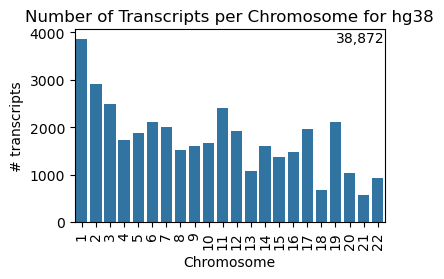

In [129]:
# Convert `chr` to integer and then to a categorical type
hg38_attr['chr'] = hg38_attr['chr'].astype(int).astype('category')

# Get distinct combinations of organism, chr, and gene_name
### Having Issues!!! getting less than expected for the number of distinct 
### values
tx_info_distinct = hg38_attr[['organism', 'chr', 'gene_name']].drop_duplicates()

# Create the plot
plt.figure(figsize=(4, 2.5))  # Adjust the figure size as needed
p = sns.countplot(data=tx_info_distinct, x='chr', dodge=False)

# Adjust plot aesthetics
plt.text(18, 3800, s=f'{len(tx_info_distinct):,}')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel('Chromosome')
plt.ylabel('# transcripts')
plt.title('Number of Transcripts per Chromosome for hg38')
plt.show()

### 4 Gene filtering
1. Multiple copies of rRNA subunits makes sense on human
2. Other abundant RNAs in this list as well
3. Filter these out to avoid confusion


In [130]:
genes_per_chrom = (tx_info_distinct
                   .groupby(['organism', 'gene_name'])
                   .size()
                   .reset_index(name='n_chr'))
filtered_genes_per_chrom = genes_per_chrom[genes_per_chrom['n_chr'] > 1]
print(filtered_genes_per_chrom)

hg38_attr = hg38_attr[~hg38_attr['gene_name'].isin(
    genes_per_chrom[genes_per_chrom['n_chr'] > 1]['gene_name']
)]

      organism    gene_name  n_chr
0         hg38      5S_rRNA      7
1         hg38    5_8S_rRNA      4
2         hg38          7SK      5
1010      hg38   ANKRD20A5P      2
5828      hg38     DDX11L16      2
5830      hg38      DDX11L2      2
16083     hg38       LSP1P5      2
19936     hg38  Metazoa_SRP     21
29503     hg38     RPL23AP7      2
32696     hg38      SNORA62      7
32697     hg38      SNORA63      6
32708     hg38      SNORA70     14
32718     hg38      SNORA71      2
32724     hg38      SNORA72      4
32725     hg38      SNORA73      2
32728     hg38      SNORA74      3
32734     hg38      SNORA75      4
32809     hg38     SNORD115      2
32858     hg38     SNORD116      3
32918     hg38      SNORD18      2
32936     hg38      SNORD27      2
32944     hg38      SNORD33      2
32957     hg38      SNORD39      4
32968     hg38      SNORD42      2
33002     hg38      SNORD63      3
33023     hg38      SNORD81      3
36458     hg38           U1      2
36459     hg38      

### remove any multiple protein coding transcripts per gene

In [131]:
# Check for the number of transcripts per gene
prot_tx_per_gene = (hg38_attr
                    .groupby(['organism', 'gene_name'])
                    .size()
                    .reset_index(name='n_tx'))

# Sample one transcript per gene where n_tx > 1
sampled_transcripts = (hg38_attr
                       .merge(prot_tx_per_gene[prot_tx_per_gene['n_tx'] > 1]
                              .sample(n=1, random_state=42), on=['organism', 'gene_name'])
                       .loc[:, ['organism', 'gene_name', 'chr', 'tx_start', 
                                'tss', 'tx_tsl', 'tx_len', 'n_tx']])

print(sampled_transcripts)

  organism gene_name chr   tx_start        tss  tx_tsl  tx_len  n_tx
0     hg38     STRBP   9  123109500  123122223       3   12722    10
1     hg38     STRBP   9  123109514  123132968       5   23453    10
2     hg38     STRBP   9  123109557  123132967       5   23409    10
3     hg38     STRBP   9  123121291  123136136       3   14844    10
4     hg38     STRBP   9  123121617  123268586       1  146968    10
5     hg38     STRBP   9  123121631  123184310       2   62678    10
6     hg38     STRBP   9  123125039  123268576       1  143536    10
7     hg38     STRBP   9  123125220  123268564       1  143343    10
8     hg38     STRBP   9  123135807  123136503       2     695    10
9     hg38     STRBP   9  123179007  123213908       3   34900    10


In [132]:
hg38_attr = hg38_attr.sort_values(by=['tx_tsl', 'tx_len'], 
                                  ascending=[True, False])

hg38_attr = hg38_attr.drop_duplicates(subset=['organism', 'gene_id', 
                                                  'gene_name'], keep='first')

In [133]:
hg38_attr

,index,organism,gene_id,tx_id,gene_name,strand,chr,tx_type,tss,tx_start,tx_end,description,tx_tsl,tx_len
76164,95730,hg38,ENSG00000174469,ENST00000361727,CNTNAP2,1,7,protein_coding,146116801,146116801,148420998,contactin associated protein 2 [Source:HGNC Sy...,1,2304196
209524,242832,hg38,ENSG00000150672,ENST00000376104,DLG2,-1,11,protein_coding,85627344,83455173,85627344,discs large MAGUK scaffold protein 2 [Source:H...,1,2172170
99892,125163,hg38,ENSG00000153707,ENST00000463477,PTPRD,-1,9,protein_coding,10612723,8528152,10612723,protein tyrosine phosphatase receptor type D [...,1,2084570
34966,45275,hg38,ENSG00000188107,ENST00000370621,EYS,-1,6,protein_coding,65707214,63720136,65707214,eyes shut homolog [Source:HGNC Symbol;Acc:HGNC...,1,1987077
54036,67855,hg38,ENSG00000168702,ENST00000389484,LRP1B,-1,2,protein_coding,142131016,140231423,142131016,LDL receptor related protein 1B [Source:HGNC S...,1,1899592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5645,8984,hg38,ENSG00000228985,ENST00000448914,TRDD3,1,14,TR_D_gene,22449113,22449113,22449125,T cell receptor delta diversity 3 [Source:HGNC...,999,11
92236,115768,hg38,ENSG00000282431,ENST00000632684,TRBD1,1,7,TR_D_gene,142786213,142786213,142786224,T cell receptor beta diversity 1 [Source:HGNC ...,999,10
89765,112182,hg38,ENSG00000236597,ENST00000439842,IGHD7-27,-1,14,IG_D_gene,105865561,105865551,105865561,immunoglobulin heavy diversity 7-27 [Source:HG...,999,9
5881,9221,hg38,ENSG00000237235,ENST00000434970,TRDD2,1,14,TR_D_gene,22439007,22439007,22439015,T cell receptor delta diversity 2 [Source:HGNC...,999,7


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


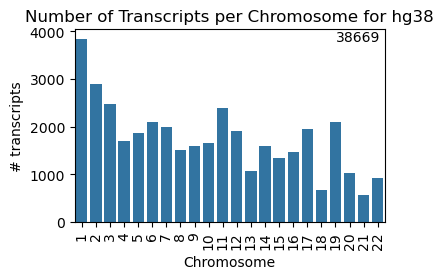

In [134]:
# Convert `chr` to integer and then to a categorical type
hg38_attr['chr'] = hg38_attr['chr'].astype(int)

# Get distinct combinations of organism, chr, and gene_name
filter_tx_info_distinct = hg38_attr[['organism', 'chr', 'gene_name']].drop_duplicates()

# Create the plot
plt.figure(figsize=(4, 2.5))  # Adjust the figure size as needed
p2 = sns.countplot(data=filter_tx_info_distinct, x='chr', dodge=False)

# Adjust plot aesthetics
plt.text(18, 3800, s=len(filter_tx_info_distinct))
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel('Chromosome')
plt.ylabel('# transcripts')
plt.title('Number of Transcripts per Chromosome for hg38')
plt.show()

In [135]:
hg38_attr.to_csv(out_dir + '/human_tx_info_filt.tsv', sep = '\t')

In [136]:
hg38_attr['tx_end'] = hg38_attr['tss'] + 1
hg38_attr['label'] = 'tss_' + hg38_attr['gene_name']

hg38_attr['chr'] = hg38_attr['chr'].apply(str)
hg38_attr['chr'] = 'chr' + hg38_attr['chr']

bed_file = hg38_attr[['chr', 'tss', 'tx_end', 'label']]
bed_file = bed_file.reset_index(drop = True)
bed_file.to_csv(out_dir + '/hg38.ew.tss.bed', sep = '\t')